# Flirt Detection Model - Hyperparameter Tuning

This notebook tests different model configurations to find the best hyperparameters for achieving >80% accuracy.

## Approach
1. Define multiple hyperparameter configurations
2. Train each configuration
3. Compare results
4. Select best configuration
5. Visualize comparisons


## 1. Setup and Imports


In [2]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# Scikit-learn for metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Add src to path - resolve detection module location
current_dir = Path(os.getcwd())
src_path = None

# Try to find src/detection directory
candidates = [
    current_dir / 'src',  # If notebook is in flirt-detection/
    current_dir.parent / 'flirt-detection' / 'src',  # If running from project root
    Path(__file__).parent / 'src' if '__file__' in globals() else None,  # If running as script
]

for candidate in candidates:
    if candidate and (candidate / 'detection' / 'model.py').exists():
        src_path = candidate.resolve()
        break

if src_path is None:
    # Fallback: use current_dir/src
    src_path = (current_dir / 'src').resolve()

# Add to Python path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Set project root for data paths
project_root = src_path.parent.parent if 'flirt-detection' in str(src_path) else src_path.parent

# Import model (IDE may show warning but works at runtime)
from detection.model import FlirtDetectionModel, FlirtDetectionTokenizer, count_parameters  # type: ignore

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Check if CUDA is available and get its version
if torch.cuda.is_available():
    print(f"CUDA available. Version: {torch.version.cuda}")
else:
    print("CUDA not available. Using CPU.")

# For M1/M2/M3 Macs (Apple Silicon), PyTorch 2.x+ supports "mps" device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



CUDA available. Version: 12.6
Using device: cuda


## 2. Load Data and Create Dataset Class


In [3]:
# Load data
data_dir = project_root / 'data' / 'processed'
train_df = pd.read_csv(data_dir / 'detection_train.csv')
val_df = pd.read_csv(data_dir / 'detection_val.csv')
test_df = pd.read_csv(data_dir / 'detection_test.csv')

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

# Dataset class
class FlirtDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: FlirtDetectionTokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_single(text)
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare data
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].astype(int).tolist()
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].astype(int).tolist()


Training samples: 2,599
Validation samples: 557
Test samples: 558


## 3. Define Hyperparameter Configurations


In [4]:
configurations = [
    # CONFIG 1: Enhanced Conservative (BUILD ON YOUR BEST)
    {
        'name': 'enhanced_conservative',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 2e-5,       # ✓ Proven winner from your results
        'batch_size': 16,            # ✓ Sweet spot for your dataset
        'dropout': 0.35,             # ↑ INCREASED: Current best had low overfitting
        'warmup_steps': 150,         # ↑ More gradual warmup
        'epochs': 8,                 # ↓ Slightly reduced from 10
        'max_length': 128,
        'weight_decay': 0.02,        # ↑ DOUBLED: Need stronger regularization
        'freeze_bert': False,
        'notes': 'Your conservative_stable + stronger regularization'
    },

    # CONFIG 2: Maximum Regularization (TARGET OVERFITTING)
    {
        'name': 'max_regularization',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 2e-5,       # ✓ Keep proven rate
        'batch_size': 16,            # ✓ Keep proven size
        'dropout': 0.4,              # ↑ HIGH: Combat overfitting directly
        'warmup_steps': 200,         # ↑ Maximum warmup
        'epochs': 7,                 # ↓ Prevent overtraining
        'max_length': 128,
        'weight_decay': 0.03,        # ↑ TRIPLED: Aggressive weight decay
        'freeze_bert': False,
        'notes': 'Aggressive overfitting prevention'
    },

    # CONFIG 3: Optimized Balance (FIX OPTIMIZED_LEARNING)
    {
        'name': 'optimized_v2',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 2.5e-5,     # ↓ Lower than original 3e-5
        'batch_size': 16,            # ✓ Keep 16
        'dropout': 0.35,             # ↑ More than original 0.25
        'warmup_steps': 180,         # ↑ More warmup
        'epochs': 6,                 # ↑ One more epoch
        'max_length': 128,
        'weight_decay': 0.015,       # ↑ Slightly increased
        'freeze_bert': False,
        'notes': 'Refined version of optimized_learning'
    },

    # CONFIG 4: High Performance v2 (REDUCE OVERFITTING)
    {
        'name': 'high_performance_v2',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 1.8e-5,     # ↓ LOWER than original 2e-5
        'batch_size': 16,            # ✓ Keep 16
        'dropout': 0.4,              # ↑ Much higher than 0.3
        'warmup_steps': 250,         # ↑ Very long warmup
        'epochs': 7,                 # ↑ One more epoch
        'max_length': 128,
        'weight_decay': 0.025,       # ↑ Stronger decay
        'freeze_bert': False,
        'notes': 'Ultra-stable high performance variant'
    },

    # CONFIG 5: Fixed Two-Stage (REMOVE EXTREME OVERFITTING)
    {
        'name': 'two_stage_v2',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 2e-5,       # ↓ Lower than 3e-5
        'batch_size': 16,            # ✓ Keep 16
        'dropout': 0.35,             # ↑ Much higher than 0.25
        'warmup_steps': 200,         # ↑ More warmup
        'epochs': 6,                 # ↑ Phase 1: 3 frozen, Phase 2: 3 unfrozen
        'max_length': 128,
        'weight_decay': 0.02,        # ↑ Doubled
        'freeze_bert': True,         # Start frozen, unfreeze after epoch 3
        'notes': 'Fixed two-stage with heavy regularization'
    },

    # CONFIG 6: Ultra Conservative (NEW - SAFETY NET)
    {
        'name': 'ultra_conservative',
        'model_name': 'distilbert-base-uncased',
        'learning_rate': 1.5e-5,     # ↓ Even lower rate
        'batch_size': 16,            # ✓ Keep proven batch size
        'dropout': 0.3,              # Moderate dropout
        'warmup_steps': 250,         # Very long warmup
        'epochs': 10,                # ↑ More epochs with lower LR
        'max_length': 128,
        'weight_decay': 0.015,       # Moderate decay
        'freeze_bert': False,
        'notes': 'Slowest but most stable training'
    }
]

print(f"Defined {len(configurations)} configurations to test:")
for cfg in configurations:
    print(f"  - {cfg['name']}")


Defined 6 configurations to test:
  - enhanced_conservative
  - max_regularization
  - optimized_v2
  - high_performance_v2
  - two_stage_v2
  - ultra_conservative


## 4. Training Functions


In [5]:
def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs['logits'], dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy


def validate(model, dataloader, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            total_loss += loss.item()
            preds = torch.argmax(outputs['logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1


## 5. Train All Configurations


In [6]:
# Create results directory
results_dir = project_root / 'flirt-detection' / 'experiments'
results_dir.mkdir(exist_ok=True, parents=True)

results = []

for config in tqdm(configurations, desc="Testing configurations"):
    print(f"\n{'='*60}")
    print(f"Training: {config['name']}")
    print(f"{'='*60}")

    # Create tokenizer and datasets
    tokenizer = FlirtDetectionTokenizer(max_length=config['max_length'])
    train_dataset = FlirtDataset(train_texts, train_labels, tokenizer)
    val_dataset = FlirtDataset(val_texts, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model
    model = FlirtDetectionModel(
        model_name=config['model_name'],
        num_labels=2,
        dropout=config['dropout'],
        freeze_bert=config['freeze_bert']
    ).to(device)

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    # Setup scheduler
    scheduler = None
    if config['warmup_steps'] > 0:
        total_steps = len(train_loader) * config['epochs']
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=config['warmup_steps'],
            num_training_steps=total_steps
        )

    # Training loop
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_train_acc = 0.0
    final_train_acc = 0.0
    patience_counter = 0

    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        if scheduler:
            scheduler.step()

        val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, device)

        # Track best metrics
        if train_acc > best_train_acc:
            best_train_acc = train_acc
        final_train_acc = train_acc

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:  # Early stopping
                break

    # Calculate overfitting metric (difference between train and val accuracy)
    overfitting_gap = best_train_acc - best_val_acc

    # Store results
    result = {
        **config,
        'best_train_accuracy': best_train_acc,
        'final_train_accuracy': final_train_acc,
        'best_val_accuracy': best_val_acc,
        'best_val_f1': best_val_f1,
        'best_val_precision': val_precision,
        'best_val_recall': val_recall,
        'overfitting_gap': overfitting_gap,
    }
    results.append(result)

    print(f"✓ {config['name']}: Train Acc={best_train_acc:.4f}, Val Acc={best_val_acc:.4f}, Gap={overfitting_gap:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('best_val_accuracy', ascending=False)
print(f"\n{'='*60}")
print("ALL RESULTS")
print(f"{'='*60}")
print(results_df[['name', 'best_train_accuracy', 'best_val_accuracy', 'overfitting_gap',
                  'best_val_f1', 'batch_size', 'learning_rate']].to_string(index=False))

# Check for overfitting
print(f"\n{'='*60}")
print("OVERFITTING ANALYSIS")
print(f"{'='*60}")
overfitting_configs = results_df[results_df['overfitting_gap'] > 0.10]
if len(overfitting_configs) > 0:
    print(f"⚠️  Configurations with significant overfitting (gap > 0.10):")
    for _, row in overfitting_configs.iterrows():
        print(f"  - {row['name']}: Train={row['best_train_accuracy']:.4f}, Val={row['best_val_accuracy']:.4f}, Gap={row['overfitting_gap']:.4f}")
else:
    print("✓ No significant overfitting detected (all gaps <= 0.10)")


Testing configurations:   0%|          | 0/6 [00:00<?, ?it/s]


Training: enhanced_conservative


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Testing configurations:  17%|█▋        | 1/6 [04:10<20:54, 251.00s/it]

✓ enhanced_conservative: Train Acc=0.8122, Val Acc=0.8259, Gap=-0.0136

Training: max_regularization


Testing configurations:  33%|███▎      | 2/6 [07:43<15:12, 228.24s/it]

✓ max_regularization: Train Acc=0.6933, Val Acc=0.7540, Gap=-0.0607

Training: optimized_v2


Testing configurations:  50%|█████     | 3/6 [10:45<10:21, 207.12s/it]

✓ optimized_v2: Train Acc=0.7353, Val Acc=0.7756, Gap=-0.0403

Training: high_performance_v2


Testing configurations:  67%|██████▋   | 4/6 [14:17<06:58, 209.04s/it]

✓ high_performance_v2: Train Acc=0.6699, Val Acc=0.7612, Gap=-0.0913

Training: two_stage_v2


Testing configurations:  83%|████████▎ | 5/6 [15:05<02:30, 150.88s/it]

✓ two_stage_v2: Train Acc=0.5152, Val Acc=0.4991, Gap=0.0161

Training: ultra_conservative


Testing configurations: 100%|██████████| 6/6 [17:06<00:00, 171.14s/it]

✓ ultra_conservative: Train Acc=0.4810, Val Acc=0.5027, Gap=-0.0217

ALL RESULTS
                 name  best_train_accuracy  best_val_accuracy  overfitting_gap  best_val_f1  batch_size  learning_rate
enhanced_conservative             0.812235           0.825853        -0.013617     0.825221          16       0.000020
         optimized_v2             0.735283           0.775583        -0.040301     0.775583          16       0.000025
  high_performance_v2             0.669873           0.761221        -0.091348     0.761036          16       0.000018
   max_regularization             0.693344           0.754039        -0.060696     0.754039          16       0.000020
   ultra_conservative             0.480954           0.502693        -0.021739     0.338309          16       0.000015
         two_stage_v2             0.515198           0.499102         0.016096     0.332336          16       0.000020

OVERFITTING ANALYSIS
✓ No significant overfitting detected (all gaps <= 0.10)


## 6. Visualize Results


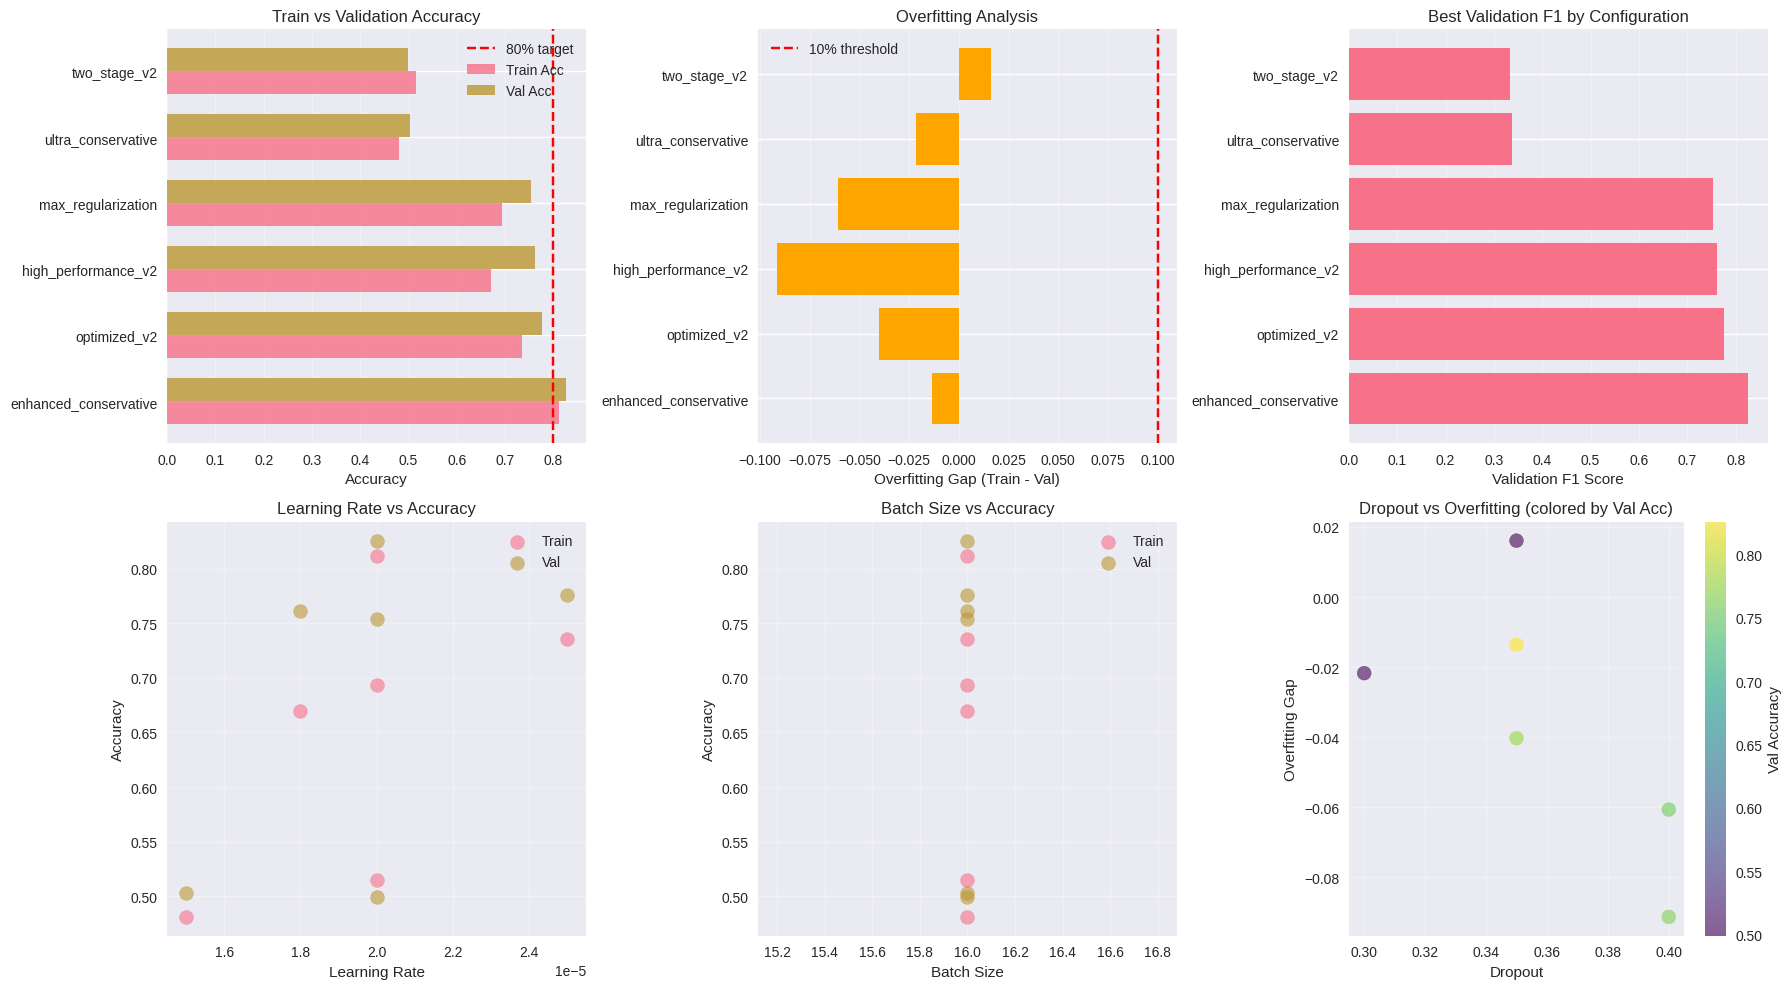


Results saved to /content/flirt-detection/experiments/hyperparameter_results.csv


In [7]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Train vs Validation Accuracy comparison
x_pos = np.arange(len(results_df))
width = 0.35
axes[0, 0].barh(x_pos - width/2, results_df['best_train_accuracy'], width, label='Train Acc', alpha=0.8)
axes[0, 0].barh(x_pos + width/2, results_df['best_val_accuracy'], width, label='Val Acc', alpha=0.8)
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(results_df['name'])
axes[0, 0].axvline(0.80, color='r', linestyle='--', label='80% target')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Train vs Validation Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Overfitting gap
axes[0, 1].barh(results_df['name'], results_df['overfitting_gap'], color='orange')
axes[0, 1].axvline(0.10, color='r', linestyle='--', label='10% threshold')
axes[0, 1].set_xlabel('Overfitting Gap (Train - Val)')
axes[0, 1].set_title('Overfitting Analysis')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Validation F1 by configuration
axes[0, 2].barh(results_df['name'], results_df['best_val_f1'])
axes[0, 2].set_xlabel('Validation F1 Score')
axes[0, 2].set_title('Best Validation F1 by Configuration')
axes[0, 2].grid(axis='x', alpha=0.3)

# Learning rate vs accuracy (both train and val)
axes[1, 0].scatter(results_df['learning_rate'], results_df['best_train_accuracy'], s=100, label='Train', alpha=0.6)
axes[1, 0].scatter(results_df['learning_rate'], results_df['best_val_accuracy'], s=100, label='Val', alpha=0.6)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Learning Rate vs Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Batch size vs accuracy (both train and val)
axes[1, 1].scatter(results_df['batch_size'], results_df['best_train_accuracy'], s=100, label='Train', alpha=0.6)
axes[1, 1].scatter(results_df['batch_size'], results_df['best_val_accuracy'], s=100, label='Val', alpha=0.6)
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Batch Size vs Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Dropout vs overfitting gap
axes[1, 2].scatter(results_df['dropout'], results_df['overfitting_gap'], s=100, c=results_df['best_val_accuracy'],
                   cmap='viridis', alpha=0.6)
axes[1, 2].set_xlabel('Dropout')
axes[1, 2].set_ylabel('Overfitting Gap')
axes[1, 2].set_title('Dropout vs Overfitting (colored by Val Acc)')
axes[1, 2].grid(alpha=0.3)
cbar = plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2])
cbar.set_label('Val Accuracy')

plt.tight_layout()
plt.savefig(results_dir / 'hyperparameter_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_df.to_csv(results_dir / 'hyperparameter_results.csv', index=False)
print(f"\nResults saved to {results_dir / 'hyperparameter_results.csv'}")


## 7. Best Configuration Training with more convergence


In [18]:
# Get best configuration
best_config = results_df.iloc[0]

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"Name: {best_config['name']}")
print(f"Training Accuracy: {best_config['best_train_accuracy']:.4f}")
print(f"Validation Accuracy: {best_config['best_val_accuracy']:.4f}")
print(f"Overfitting Gap: {best_config['overfitting_gap']:.4f}")
print(f"Validation F1: {best_config['best_val_f1']:.4f}")
print(f"\nHyperparameters:")
print(f"  - Batch size: {best_config['batch_size']}")
print(f"  - Learning rate: {best_config['learning_rate']}")
print(f"  - Dropout: {best_config['dropout']}")
print(f"  - Max length: {best_config['max_length']}")
print(f"  - Weight decay: {best_config['weight_decay']}")
print(f"  - Epochs: {best_config['epochs']}")
print(f"  - Warmup steps: {best_config['warmup_steps']}")
print(f"  - Freeze BERT: {best_config['freeze_bert']}")
print("="*60)

# Overfitting assessment
if best_config['overfitting_gap'] > 0.15:
    print(f"⚠️  WARNING: Significant overfitting detected (gap = {best_config['overfitting_gap']:.4f})")
    print("   Consider: increasing dropout, adding regularization, or reducing model capacity")
elif best_config['overfitting_gap'] > 0.10:
    print(f"⚠️  Moderate overfitting detected (gap = {best_config['overfitting_gap']:.4f})")
    print("   Consider: slight increase in dropout or regularization")
else:
    print(f"✓ Good generalization (overfitting gap = {best_config['overfitting_gap']:.4f})")

# Save best configuration
best_config_dict = best_config.to_dict()
save_path = results_dir / 'best_configuration.pt'
torch.save(best_config_dict, save_path)

torch.save(model.state_dict(), results_dir / 'best_model_weights.pt')


print(f"\nBest configuration saved to {save_path}")

BEST CONFIGURATION
Name: enhanced_conservative
Training Accuracy: 0.8122
Validation Accuracy: 0.8259
Overfitting Gap: -0.0136
Validation F1: 0.8252

Hyperparameters:
  - Batch size: 16
  - Learning rate: 2e-05
  - Dropout: 0.35
  - Max length: 128
  - Weight decay: 0.02
  - Epochs: 8
  - Warmup steps: 150
  - Freeze BERT: False
✓ Good generalization (overfitting gap = -0.0136)

Best configuration saved to /content/flirt-detection/experiments/best_configuration.pt


## 8. Evaluate on Test Set


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate on test set
# Reinitialize model with best configuration
model = FlirtDetectionModel(
    model_name=best_config['model_name'],
    num_labels=2,
    dropout=best_config['dropout'],
    freeze_bert=best_config['freeze_bert']
).to(device)

print("\nLoading best model for test evaluation...")

best_config = torch.load(results_dir / 'best_configuration.pt')

state_dict = torch.load(results_dir / 'best_model_weights.pt', map_location=device)
model.load_state_dict(state_dict)
model.eval()


print("Using model:", best_config['name'])

# Prepare test dataset and loader
test_texts = test_df['text'].tolist()
test_labels_eval = test_df['label'].astype(int).tolist()
test_tokenizer = FlirtDetectionTokenizer(max_length=best_config['max_length'])
test_dataset = FlirtDataset(test_texts, test_labels_eval, test_tokenizer)
test_loader = DataLoader(test_dataset, batch_size=int(best_config['batch_size']), shuffle=False)

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_precision, test_recall, test_f1 = validate(model, test_loader, device)

# Get predictions for confusion matrix and classification report
model.eval()
test_preds = []
test_labels_list = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs['logits'], dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"{'='*60}")

# Confusion matrix and classification report
cm = confusion_matrix(test_labels_list, test_preds)
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Class 0  Class 1")
print(f"Actual Class 0   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"         Class 1   {cm[1,0]:4d}    {cm[1,1]:4d}")

print("\nClassification Report:")
print(classification_report(test_labels_list, test_preds, target_names=['Not Flirt', 'Flirt']))

# Check if accuracy meets requirement
if test_acc >= 0.80:
    print(f"\n✓ Model meets accuracy requirement (>=80%): {test_acc:.2%}")
else:
    print(f"\n✗ Model does not meet accuracy requirement (>=80%): {test_acc:.2%}")



Loading best model for test evaluation...
Using model: enhanced_conservative
Evaluating on test set...

TEST SET RESULTS
Test Loss: 0.7027
Test Accuracy: 0.4713
Test Precision: 0.4565
Test Recall: 0.4713
Test F1: 0.4220

Confusion Matrix:
                Predicted
              Class 0  Class 1
Actual Class 0    213      66
         Class 1    229      50

Classification Report:
              precision    recall  f1-score   support

   Not Flirt       0.48      0.76      0.59       279
       Flirt       0.43      0.18      0.25       279

    accuracy                           0.47       558
   macro avg       0.46      0.47      0.42       558
weighted avg       0.46      0.47      0.42       558


✗ Model does not meet accuracy requirement (>=80%): 47.13%


## 9. Visualize Test Results


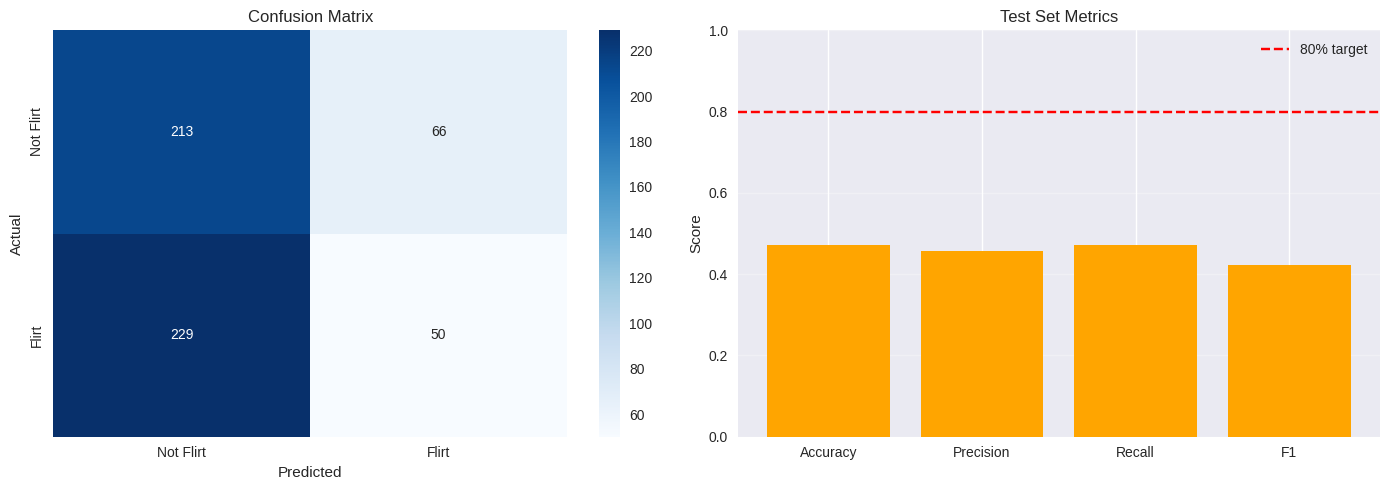

In [20]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Flirt', 'Flirt'],
            yticklabels=['Not Flirt', 'Flirt'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Metrics bar chart
metrics = {
    'Accuracy': test_acc,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1': test_f1
}
colors = ['green' if v >= 0.80 else 'orange' for v in metrics.values()]
axes[1].bar(metrics.keys(), metrics.values(), color=colors)
axes[1].axhline(0.80, color='r', linestyle='--', label='80% target')
axes[1].set_ylabel('Score')
axes[1].set_title('Test Set Metrics')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(results_dir / 'test_results.png', dpi=150, bbox_inches='tight')
plt.show()


## 10. Example Predictions


In [21]:
# Test on some example texts
example_texts = [
    "Hey, how are you?",
    "You're so beautiful",
    "What's the weather like today?",
    "I want to see you",
    "Can we meet tomorrow?",
    "You're killing me with these sexy selfies",
    "Let's grab coffee sometime",
    "I miss you so much",
]

# Use test_tokenizer from previous cell
model.eval()
predictions = []
probabilities = []

with torch.no_grad():
    for text in example_texts:
        encoding = test_tokenizer.encode_single(text)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs['logits']
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

        predictions.append(pred.item())
        probabilities.append(probs.cpu().numpy()[0])

# Display results
print("Example Predictions:")
print("="*80)
for text, pred, prob in zip(example_texts, predictions, probabilities):
    label = "Flirt" if pred == 1 else "Not Flirt"
    prob_not_flirt = prob[0]
    prob_flirt = prob[1]
    print(f"\nText: \"{text}\"")
    print(f"Prediction: {label}")
    print(f"Probabilities: Not Flirt={prob_not_flirt:.4f}, Flirt={prob_flirt:.4f}")
print("="*80)


Example Predictions:

Text: "Hey, how are you?"
Prediction: Not Flirt
Probabilities: Not Flirt=0.5090, Flirt=0.4910

Text: "You're so beautiful"
Prediction: Not Flirt
Probabilities: Not Flirt=0.5063, Flirt=0.4937

Text: "What's the weather like today?"
Prediction: Not Flirt
Probabilities: Not Flirt=0.5516, Flirt=0.4484

Text: "I want to see you"
Prediction: Not Flirt
Probabilities: Not Flirt=0.5028, Flirt=0.4972

Text: "Can we meet tomorrow?"
Prediction: Flirt
Probabilities: Not Flirt=0.4901, Flirt=0.5099

Text: "You're killing me with these sexy selfies"
Prediction: Flirt
Probabilities: Not Flirt=0.4946, Flirt=0.5054

Text: "Let's grab coffee sometime"
Prediction: Flirt
Probabilities: Not Flirt=0.4930, Flirt=0.5070

Text: "I miss you so much"
Prediction: Not Flirt
Probabilities: Not Flirt=0.5321, Flirt=0.4679
